<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/Flower_Recognition_Challenges_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import copy
import time
import tqdm
import torch
import mlxtend
import warnings
import operator
import matplotlib
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics, preprocessing

In [3]:
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#PyTorch-Flowers-TransLearing+Ensemble
[Note Book](https://www.kaggle.com/code/georgiisirotenko/pytorch-flowers-translearing-ensemble-test-99-67)

##1.Get Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip \*.zip && rm *.zip

**plotImg_Hist**

input: image file , is_path=False

OR

input: image path , is_path=True

output: None

this function, gets image file and plots it's pixel intensity and the image itself.

you can give image path to this function too and expect the same results, but just remmember to set 'is_path=True'


In [5]:
def plotImg_Hist(img, is_path=False):
  if is_path:
    img = matplotlib.image.imread(img)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.axis('off')
  hist = plt.subplot(1, 2, 2)
  hist.set_ylabel('Count')
  hist.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, alpha=0.5, color='r')

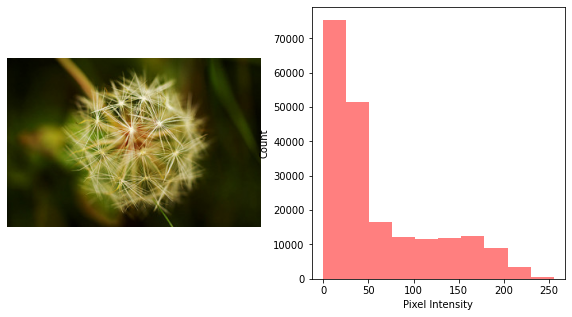

In [6]:
test_img = matplotlib.image.imread('/content/flowers/dandelion/10043234166_e6dd915111_n.jpg')
plotImg_Hist(test_img)

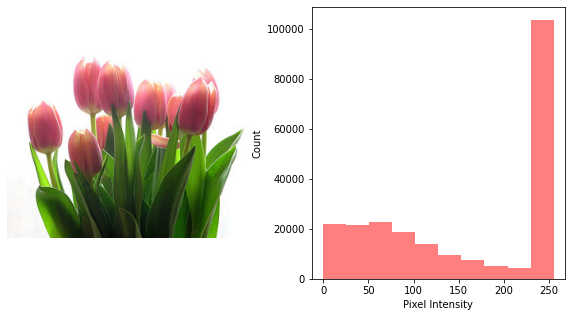

In [7]:
plotImg_Hist('/content/flowers/tulip/112428665_d8f3632f36_n.jpg', is_path=True)

##2.Data Prepration

The "original" dataset is the original dataset and others are some augmentations of it.

In [8]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)
transformer = {
    'original': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset1': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                               torchvision.transforms.RandomRotation(5),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset2': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(),
                                               torchvision.transforms.RandomRotation(10),
                                               torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.RandomErasing(inplace=True, scale=(0.01,  0.23)),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
    'dataset3': torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((220, 220)),
                                               torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                               torchvision.transforms.RandomRotation(15),
                                               torchvision.transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize(mean, std)
    ]),
}

**pin_memory**: You know how sometimes your GPU memory shows that it’s full but you’re pretty sure that your model isn’t using that much? 

That overhead is called pinned memory. 

ie: this memory has been reserved as a type of “working allocation.” When you enable pinned_memory in a DataLoader it “automatically puts the fetched data Tensors in pinned memory, and enables faster data transfer to CUDA-enabled GPUs”

**num_workers**: PyTorch allows loading data on multiple processes simultaneously. A good rule: num_worker = 4 num_GPU*

In [9]:
path = '/content/flowers/'

#all dataset ==> train&val + test
original = torchvision.datasets.ImageFolder(path, transform=transformer['original'])
train_val, test = model_selection.train_test_split(original, test_size=0.2, random_state=32, shuffle=True)

# train_val  ==> train + val + dataset1 + dataset2 + dataset3
train_val = torch.utils.data.ConcatDataset([train_val,
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset1']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset2']),
                                torchvision.datasets.ImageFolder(path, transform=transformer['dataset3'])])

train, val = model_selection.train_test_split(train_val, test_size=0.1, shuffle=True, random_state=32)

In [10]:
batch_size=32
data_loaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=4, pin_memory=True),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=4, pin_memory=True)
}

dataset_sizes = {
    'train': len(train),
    'val': len(val),
    'test': len(test)
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: 

In [11]:
dataset_sizes

{'test': 864, 'train': 14763, 'val': 1641}

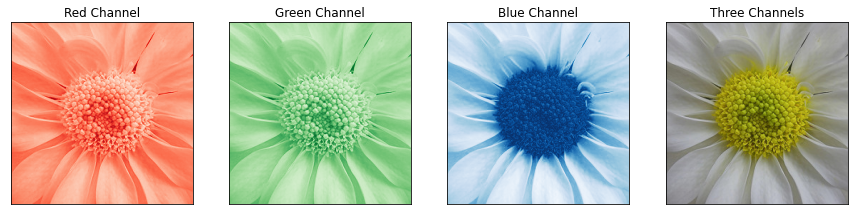

In [12]:
exampleset = torchvision.datasets.ImageFolder(path, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                            torchvision.transforms.CenterCrop(255)]))

x, y = next(iter(torch.utils.data.DataLoader(exampleset)))

channels = ['Red', 'Green', 'Blue']
cmaps = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, axs in enumerate(fig.axes[:3]):
    axs.imshow(x[0][i,:,:], cmap=cmaps[i])
    axs.set_title(f'{channels[i]} Channel')
    axs.set_xticks([])
    axs.set_yticks([])
    
ax[3].imshow(x[0].permute(1,2,0))
ax[3].set_title('Three Channels')
ax[3].set_xticks([])
ax[3].set_yticks([]);

Now let's check how well we managed to normalize the data for each channel for the test/train/val datasets:



In [30]:
for channel in range(3):
  for x in ['train', 'val', 'test']:
    #number of all pixels in the dataset = number of pixels in each image * number of all images in the dataset
    pixels_count = dataset_sizes[x] * 220 * 220
    total_sum = 0
    for batch in data_loaders[x]:
      layer = list(map(operator.itemgetter(channel), batch[0]))    
      layer = torch.stack(layer, dim=0)
      total_sum += layer.sum()
    mean = total_sum / pixels_count
    
    sum_sqrt=0
    for batch in data_loaders[x]:
      layer = list(map(operator.itemgetter(channel), batch[0]))    
      sum_sqrt += ((torch.stack(layer, dim=0) - mean).pow(2)).sum()
    std = torch.sqrt(sum_sqrt / pixels_count)

    print(f'channel: {channel+1}| {x} - mean: {mean:.3f}, std: {std:.3f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 1| train - mean: -0.188, std: 0.987


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 1| val - mean: -0.193, std: 0.985


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 1| test - mean: 0.124, std: 0.897


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 2| train - mean: -0.161, std: 0.996


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 2| val - mean: -0.158, std: 0.995


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 2| test - mean: 0.174, std: 0.891


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 3| train - mean: -0.099, std: 0.964


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 3| val - mean: -0.094, std: 0.967


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


channel: 3| test - mean: 0.141, std: 0.984


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0873) tensor(0.9827)


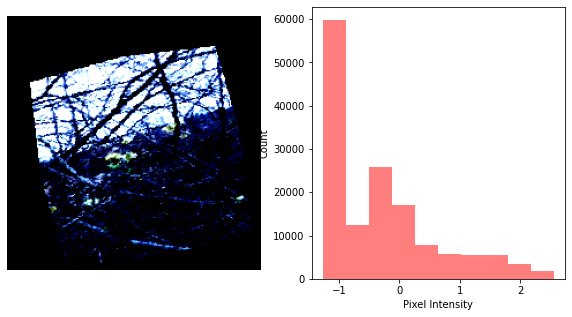

In [14]:
z, _ = next(iter(data_loaders['train']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plotImg_Hist(img_norm)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.1916) tensor(0.9389)


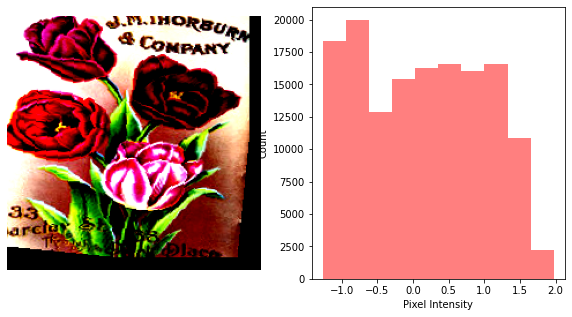

In [15]:
z, _ = next(iter(data_loaders['val']))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plotImg_Hist(img_norm)

How ImBalance is ourdaset

In [16]:
dic = {}
for cls in original.classes:
  dic[cls] = len(os.listdir(f'{path}{cls}'))

In [17]:
samplesize = pd.DataFrame(dic, index=[0])
samplesize

,daisy,dandelion,rose,sunflower,tulip
0,764,1052,784,733,984


The imbalance is small and we do not need to handle it in any way, since the ratio of the largest class to the smallest is 1.47, which is not much

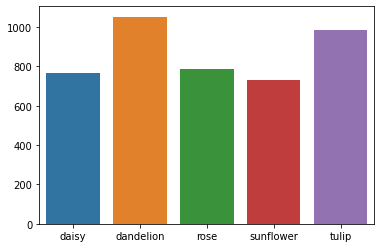

In [18]:
sns.barplot(data=samplesize)

In [19]:
def plot_imgs(imgs, nrows=5, ncols=5):
  fig, ax = plt.subplots(nrows, ncols, figsize=(5, 3))
  index = 0
  for row in range(nrows):
    for col in range(ncols):
      img = matplotlib.image.imread(imgs[index][0])
      ax[row][col].imshow(img)
      ax[row][col].axis('off')
      ax[row][col].set_title(imgs[index][1], fontsize=15)
      index += 1

In [20]:
def rand_imgs(original, img_folder=path, count=25):
  rand_imgs = []
  categories = original.classes
  for cat in categories:
    folder_path = f"{img_folder}{cat}"
    imgs_list = os.listdir(folder_path)
    selected_imgs = np.random.choice(imgs_list, count//len(categories))
    rand_imgs.extend([(f'{folder_path}/{img_path}', cat) for img_path in selected_imgs])
  np.random.shuffle(rand_imgs)
  return rand_imgs

In [21]:
my_imgs = rand_imgs(original, path, 5)
my_imgs

[('/content/flowers/daisy/2862944799_45bc8e7302.jpg', 'daisy'),
 ('/content/flowers/rose/1666341535_99c6f7509f_n.jpg', 'rose'),
 ('/content/flowers/dandelion/4275776457_d04b597cfa_n.jpg', 'dandelion'),
 ('/content/flowers/sunflower/15043962658_dcf9dff5e9_n.jpg', 'sunflower'),
 ('/content/flowers/tulip/7166552648_28b6dce578_n.jpg', 'tulip')]

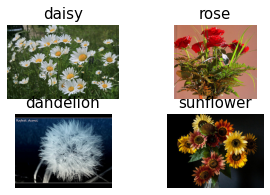

In [22]:
plot_imgs(my_imgs, 2, 2)

In [23]:
def plot_batch(data_loader):
  for imgs, labels in data_loader:
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.imshow(torchvision.utils.make_grid(imgs[:60], nrow=10).permute(1, 2, 0))
    ax.set_title('Augmented Images')
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


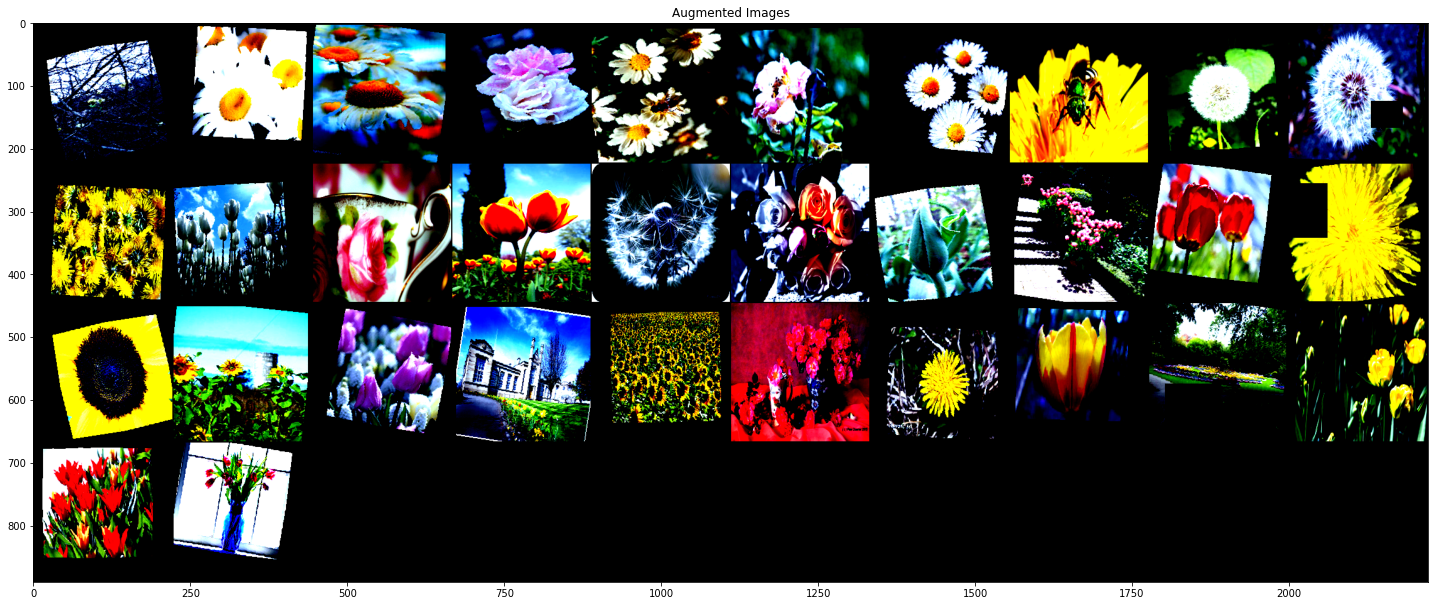

In [24]:
plot_batch(data_loaders['train'])

In [ ]:
plot_batch(data_loaders['val'])

In [ ]:
plot_batch(data_loaders['test'])

#Train

In [26]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds)), preds

In [27]:
losses = {'train': [], 'val':[]}
accuracies = {'train': [], 'val':[]}
lr = []

In [31]:
def train(params, model):
  
  seed = params['seed']
  epochs = params['epochs']
  optimizer = params['optimizer']
  criterion = params['criterion']
  data_loaders = params['data_loaders']
  requires_grad = params['requires_grad']
  scheduler = params['scheduler']
  print(f'Create a model {seed}')

  for param in model.parameters():
    param.requires_grad=requires_grad

  model.to(device) 
  start = time.time()  
  best_accuracy = 0.0
  best_loss = float('inf')
  best_model = copy.deepcopy(model.state_dict())

  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for input, labels in data_loaders[phase]:
        inputs = input.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
      
      with torch.set_grad_enabled(phase=='train'):
        output = model(inputs)
        _, pred = torch.max(output, 1)
        loss = criterion(output, labels)
        if phase == True:
          loss.backward()
          optimizer.step()
          lr.append(scheduler.get_lr())
          scheduler.step()
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(pred == labels.data)

      if phase == 'train':
        acc = 100 * running_corrects.double() / dataset_sizes[phase]
        scheduler.step(acc)
      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print(f'Epoch: {epoch+1}/{epochs}')
      print(f'{phase} - Loss: {epoch_loss}, Accuracy: {epoch_acc}')
      lr.append(scheduler)

      if phase == 'val':
        during = time.time() - start
        print(f'Time: {during//60}m {during%60}s')
        print('======'*5)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
  
  during = time.time() - start
  print(f'Classifier training Time: {during//60}m {during%60}s')
  print('======'*5)

  model.load_state_dict(best_model)        

  for param in model.parameters():
    param.requires_grad=True
  

In [ ]:

# optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_ddecat=1e-5)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_ddecat=0)/

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True),
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamm=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.1, epochs=epochs, steps_per_epoch=len(data_loaders['train']), cycle_momentum=True),

epochs = 20
batch_size = 32
params = {
    'seed': seed,
    'epochs': epochs,
    'data_loaders': data_loaders,
    'criterion': torch.nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'requires_grad': False,
    'scheduler': scheduler
}

#Models

###1.DenseNet

In [34]:
densenet121 = torchvision.models.densenet121(pretrained=True)

for param in densenet121.parameters():
  param.requires_grad=False

densenet121.classifier = torch.nn.Linear(in_features=densenet121.classifier.in_features,
                                           out_features=len(original.classes),
                                           bias=True)

###2.GoogleNet

In [37]:
googlenet = torchvision.models.googlenet(pretrained=True)
for param in googlenet.parameters():
  param.grad_requires = False

googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, 
                               out_features= len(original.classes),
                               bias=True)

###3.ResNet

In [ ]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for param in resnet101.parameters():
  param.grad_requires = False

resnet101.fc = torch.nn.Linear(resnet101.fc.in_features, 
                               out_features= len(original.classes),
                               bias=True)

###4.VGG19



In [ ]:
vgg19_bn = torchvision.models.vgg19_bn(pretrained=True)
for param in vgg19_bn.parameters():
  param.grad_requires = False

vgg19_bn.classifier[6] = torch.nn.Linear(4096, 
                               out_features= len(original.classes),
                               bias=True)

###Launch training

In [41]:
num_models = 5
epochs = 10

models = [densenet121, googlenet, resnet101, vgg19_bn]